# ***TEAM1 Final Presentation***

# **CNN 알고리즘을 활용한 건설현장 근로자 안전모 착용여부 인식 모델 개발**



*   산업현장의 재해율이 지속적으로 감소하는 데 반해 건설현장의 재해율은 점진적으로 증가하는 추세
*   특히 건설업 사망재해 심각
*   상해 부위 中 두부 손상으로 인한 경우가 전체의 43%
*   딥러닝을 기반으로 한 안전모 착용 여부 인식 모델을 개발해 적용





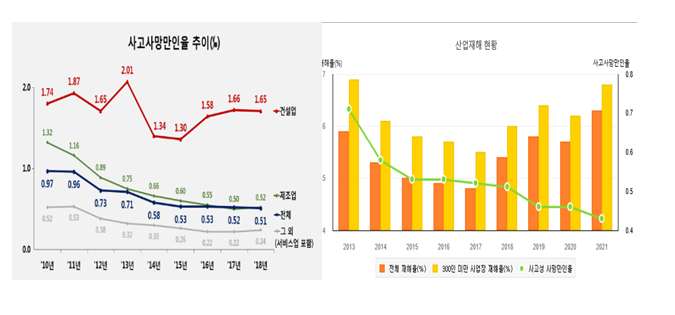

In [ ]:
import zipfile
import os
import json
import shutil
from tqdm import tqdm
from glob import glob
import json
import cv2
import matplotlib.pyplot as plt
import zipfile
from tqdm import tqdm
from glob import glob
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import math
import numpy as np
import pandas as pd
from tensorflow.keras.applications import ResNet50
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Flatten
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
from PIL import Image
import random
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.cm
from tensorflow.keras.models import load_model
import PIL
from IPython.display import Image, display, Javascript
import os
from google.colab.output import eval_js
import cv2
from base64 import b64decode
import requests


from glob import glob
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import time
import copy
import random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# ***RawData Preprocessing***

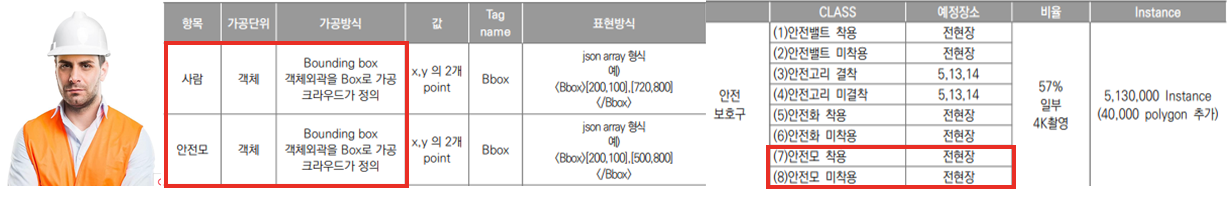

* Data : AI 허브 "공사현장 안전장비 인식 이미지 소개" (https://aihub.or.kr/aidata/33921)
  * 안전 보호구 > 안전모 착용/미착용 이미지만 사용!
  * Colab Pro 환경에서 처리할 수 있도록 전체 데이터 랜덤다운샘플링을 통한 개수 조정

In [ ]:
# 안전모 착용/미착용 이미지만 select하기
path = "/content/gdrive/MyDrive/Project/deeplearning/공사현장 안전장비 인식 이미지/Training/[라벨]2.공연장/부산 오페라 하우스 신축공사/5.전체/"
file_list = os.listdir(path)
file_list_json = [file for file in file_list]

file_list_class = []
file_list_class07 = []
file_list_class08 = []

for file in file_list_json :
    with open(path+"/"+file, "r", encoding="utf8") as f:
        contents = f.read()
        json_data = json.loads(contents)
        for i in range(len(json_data["annotations"])) :
            if (json_data["annotations"][i]["class"] == '07') :
                file_list_class.append(file.replace(".json",''))
                file_list_class07.append(file.replace(".json",''))
                break
            elif (json_data["annotations"][i]["class"] == '08') :
                if (file not in file_list_class) :
                    file_list_class.append(file.replace(".json",''))
                file_list_class08.append(file.replace(".json",''))
                break

imgpath = "/content/gdrive/MyDrive/Project/deeplearning/공사현장 안전장비 인식 이미지/Training/[원천]2.공연장/"
imgfile_destination = '/content/gdrive/MyDrive/Project/deeplearning/RawData/img_data/'
jsonfile_destination = '/content/gdrive/MyDrive/Project/deeplearning/RawData/json_data/'
for i in range(len(file_list_class)) :
  shutil.copy(imgpath + file_list_class[i] + '.jpg', imgfile_destination  + file_list_class[i] + '.jpg')
  shutil.copy(path + file_list_class[i] + '.json', jsonfile_destination  + file_list_class[i] + '.json')

In [ ]:
# 데이터 개수 줄이기
json_file_lists = os.listdir('/content/gdrive/MyDrive/Project/deeplearning/RawData/json_data')
final_json_file = random.sample(json_file_lists, 8000)   # 전체 데이터의 1/10

for fname in final_json_file:
  filename = final_json_file.split('.')[0]
  json_src = os.path.join('/content/gdrive/MyDrive/Project/deeplearning/RawData/json_data', fname)
  json_dst = os.path.join('/content/gdrive/MyDrive/Project/deeplearning/Data/json_data', fname)
  img_src = os.path.join('/content/gdrive/MyDrive/Project/deeplearning/RawData/img_data', filename+'.jpg')
  img_dst = os.path.join('/content/gdrive/MyDrive/Project/deeplearning/Data/img_data', filename+'.jpg')
  shutil.copyfile(json_src,json_dst)
  shutil.copyfile(img_src,img_dst)

# ***CNN 기반 Binary Classification Models***

* **CNN**
  * SimpleCNN
* **Pretrained**
  * VGG16
  * ResNet50
  * MobileNet

In [ ]:
# 그래프 Smoothing 함수 선언

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor+point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

### 데이터 전처리




*   약 1만장의 이미지 데이터 사용
*   원 데이터의 Helmet (07) No_Helmet (08) 라벨을 이용하여 헬멧을 쓴사람과 안쓴사람 얼굴 부분만 자름
*   Train Validation Test 디렉터리 생성 후 이미지 6:2:2로 Split한 후 각 디렉터리에 Helmet / No_Helmet 데이터 각각 저장
*   이미지 파일을 전치리된 배치 탠서로 바꾸기 위해 ImageDataGenerator 클래스 사용
*   train_generator / val_generator / test_generator
*   증식 적용 -> train_aug_generator / val_aug_generator / test_aug_generator











In [ ]:
imgfile = '/content/gdrive/MyDrive/Project/deeplearning/RawData/img_data/'
jsonfile = '/content/gdrive/MyDrive/Project/deeplearning/RawData/json_data/'
json_lists = os.listdir(jsonfile)

for k in range(len(json_lists)) :
    with open('/content/gdrive/MyDrive/Project/deeplearning/RawData/json_data/{}'.format(json_lists[k]), 'r', encoding = "utf-8-sig") as f:
        json_data = json.load(f)
    img = imgfile + json_lists[k].split('.')[0]+'.jpg'
    for i in range(len(json_data['annotations'])) :
        if int(json_data['annotations'][i]['class'])==7 :
            box = json_data['annotations'][i]['box']
            src = cv2.imread(img, cv2.IMREAD_UNCHANGED)
            # 이미지를 자른다.
            dst = src[box[1]:box[3], box[0]:box[2]].copy()
            cv2.imwrite('/content/gdrive/MyDrive/Project/deeplearning/cutimage/07/{}_{}.jpg'.format(json_lists[k].split('.')[0],i), dst)

        elif int(json_data['annotations'][i]['class'])==8:
            box = json_data['annotations'][i]['box']
            src = cv2.imread(img, cv2.IMREAD_UNCHANGED)

            # 이미지를 자른다.
            dst = src[box[1]:box[3], box[0]:box[2]].copy()
            cv2.imwrite('/content/gdrive/MyDrive/Project/deeplearning/cutimage/08/{}_{}.jpg'.format(json_lists[k].split('.')[0],i), dst)

    f.close()

Train, Test, Validation 분류

In [ ]:
# 디렉터리 생성
original_dataset_dir = '/content/gdrive/MyDrive/Project/deeplearning/cutimage'

base_dir = '/content/gdrive/MyDrive/Project/deeplearning/cutimage/split'
os.mkdir(base_dir)

for i in ['train','validation','test'] :
  dir = os.path.join(base_dir,i)
  helmet_dir = os.path.join(dir,'Helmet') # 훈련용 헬멧 디렉터리
  no_helmet_dir = os.path.join(dir, 'No_Helmet') # 훈련용 헬멧x 디렉터리
  os.mkdir(dir)
  os.mkdir(helmet_dir)
  os.mkdir(no_helmet_dir)

In [ ]:
original_seven_dir = '/content/gdrive/MyDrive/Project/deeplearning/cutimage/07'
original_eight_dir = '/content/gdrive/MyDrive/Project/deeplearning/cutimage/08'

# 07/08 이미지파일명 리스트화
img_seven_lists = os.listdir(original_seven_dir)
img_eight_lists = os.listdir(original_eight_dir)

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')

train_helmet_dir = os.path.join(train_dir,'Helmet')
train_no_helmet_dir = os.path.join(train_dir, 'No_Helmet')
validation_helmet_dir = os.path.join(validation_dir,'Helmet')


validation_no_helmet_dir = os.path.join(validation_dir, 'No_Helmet')
test_helmet_dir = os.path.join(test_dir,'Helmet')
test_no_helmet_dir = os.path.join(test_dir, 'No_Helmet')

In [ ]:
# Helmet train 이미지 train_helmet_dir에 저장
Helmet_train_fnames = []
for k in range(math.floor(len(img_seven_lists)*0.6)):
  Helmet_train_fnames.append(img_seven_lists[k])

for fname in Helmet_train_fnames:
  src = os.path.join(original_seven_dir, fname)
  dst = os.path.join(train_helmet_dir, fname)
  shutil.copyfile(src,dst)

# Helmet validation 이미지 validation_helmet_dir에 저장
Helmet_validation_fnames = []
for k in range(math.floor(len(img_seven_lists)*0.6),math.floor(len(img_seven_lists)*0.8)):
  Helmet_validation_fnames.append(img_seven_lists[k])

for fname in Helmet_validation_fnames:
  src = os.path.join(original_seven_dir, fname)
  dst = os.path.join(validation_helmet_dir, fname)
  shutil.copyfile(src,dst)

# Helmet Test 이미지 test_helmet_dir에 저장
Helmet_Test_fnames = []
for k in range(math.floor(len(img_seven_lists)*0.8),len(img_seven_lists)):
  Helmet_Test_fnames.append(img_seven_lists[k])

for fname in Helmet_Test_fnames:
  src = os.path.join(original_seven_dir, fname)
  dst = os.path.join(test_helmet_dir, fname)
  shutil.copyfile(src,dst)

# No_Helmet Train 이미지 train_no_helmet_dir에 저장
No_Helmet_train_fnames = []
for k in range(math.floor(len(img_eight_lists)*0.6)):
  No_Helmet_train_fnames.append(img_eight_lists[k])

for fname in No_Helmet_train_fnames:
  src = os.path.join(original_eight_dir, fname)
  dst = os.path.join(train_no_helmet_dir, fname)
  shutil.copyfile(src,dst)


# No_Helmet validation 이미지 validation_no_helmet_dir에 저장
No_Helmet_validation_fnames = []
for k in range(math.floor(len(img_eight_lists)*0.6),math.floor(len(img_eight_lists)*0.8)):
  No_Helmet_validation_fnames.append(img_eight_lists[k])

for fname in No_Helmet_validation_fnames:
  src = os.path.join(original_eight_dir, fname)
  dst = os.path.join(validation_no_helmet_dir, fname)
  shutil.copyfile(src,dst)

# No_Helmet test 이미지 test_no_helmet_dir에 저장
No_Helmet_test_fnames = []
for k in range(math.floor(len(img_eight_lists)*0.8),len(img_eight_lists)):
  No_Helmet_test_fnames.append(img_eight_lists[k])

for fname in No_Helmet_test_fnames:
  src = os.path.join(original_eight_dir, fname)
  dst = os.path.join(test_no_helmet_dir, fname)
  shutil.copyfile(src,dst)

In [ ]:
print('훈련용 Helmet 이미지 개수 : ', len(os.listdir(train_helmet_dir)))
print('검증용 Helmet 이미지 개수 : ', len(os.listdir(validation_helmet_dir)))
print('테스트용 Helmet 이미지 개수 : ', len(os.listdir(test_helmet_dir)))
print('훈련용 No_Helmet 이미지 개수 : ', len(os.listdir(train_no_helmet_dir)))
print('검증용 No_Helmet 이미지 개수 : ', len(os.listdir(validation_no_helmet_dir)))
print('테스트용 No_Helmet 이미지 개수 : ', len(os.listdir(test_no_helmet_dir)))

In [ ]:
# Train / Test Scale 조정 / 이미지 Shuffle / 증식 X
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/HelmetData/cutimage/split/train',
                                                            target_size=(150,150),
                                                            batch_size=32,
                                                            class_mode='binary',
                                                            shuffle = True
                                                            )

test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/HelmetData/cutimage/split/test',
                                                            target_size=(150,150),
                                                            batch_size=32,
                                                            class_mode='binary',
                                                            shuffle = True
                                                            )

val_generator = val_datagen.flow_from_directory('/content/gdrive/MyDrive/HelmetData/cutimage/split/validation',
                                                target_size=(150,150),
                                                            batch_size=32,
                                                            class_mode='binary',
                                                            shuffle = True
                                                            )

Found 6000 images belonging to 2 classes.
Found 1999 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
# 증식 적용
train_aug_datagen = ImageDataGenerator(rotation_range = 90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
test_aug_datagen = ImageDataGenerator(rescale=1./255)
val_aug_datagen = ImageDataGenerator(rescale=1./255)

train_aug_generator = train_aug_datagen.flow_from_directory('/content/gdrive/MyDrive/HelmetData/cutimage/split/train',
                                                            target_size=(150,150),
                                                            batch_size=32,
                                                            class_mode='binary',
                                                            shuffle = True
                                                            )

test_aug_generator = test_aug_datagen.flow_from_directory('/content/gdrive/MyDrive/HelmetData/cutimage/split/test',
                                                            target_size=(150,150),
                                                            batch_size=32,
                                                            class_mode='binary',
                                                            shuffle = True
                                                            )

val_aug_generator = val_aug_datagen.flow_from_directory('/content/gdrive/MyDrive/HelmetData/cutimage/split/validation',
                                                        target_size=(150,150),
                                                            batch_size=32,
                                                            class_mode='binary',
                                                            shuffle = True )

Found 6000 images belonging to 2 classes.
Found 1999 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## ***Simple Convnet***



*   Conv2D와 Maxpooling2D층을 번갈아 쌓은 컨브넷 구성
*   특성 맵의 크기 감소



Simple Convnet에 증식 X Generator

In [ ]:
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import Dropout

basic_model = models.Sequential()
basic_model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
basic_model.add(layers.MaxPooling2D((2,2)))
basic_model.add(layers.Conv2D(32,(3,3), activation='relu'))
basic_model.add(layers.MaxPooling2D((2,2)))
basic_model.add(layers.Conv2D(64,(3,3),activation='relu'))
basic_model.add(layers.MaxPooling2D((2,2)))
basic_model.add(layers.Conv2D(64,(3,3),activation='relu'))
basic_model.add(layers.MaxPooling2D((2,2)))

basic_model.add(layers.Flatten())
basic_model.add(layers.Dense(512, activation='relu'))
basic_model.add(layers.Dense(1, activation='sigmoid'))

basic_model.summary()

from tensorflow.keras import optimizers

basic_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

In [ ]:
basic_history = basic_model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=test_generator,
                              validation_steps=16)

In [ ]:
## Accuracy loss Graph

import matplotlib.pyplot as plt

acc = basic_history.history['acc']
val_acc = basic_history.history['val_acc']
loss = basic_history.history['loss']
val_loss = basic_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

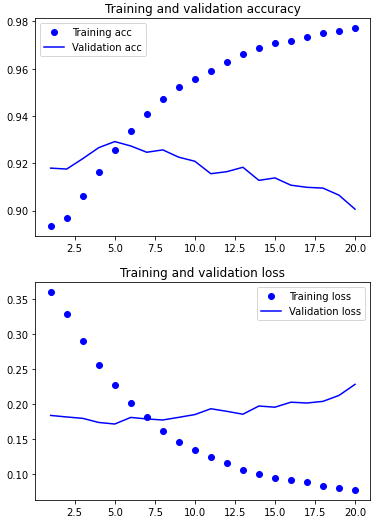

In [ ]:
basic_model = load_model('/content/gdrive/MyDrive/savemodel/basic_model.h5')

In [ ]:
results = basic_model.evaluate(test_generator, steps=len(test_generator))

63/63 [==============================] - 1328s 21s/step - loss: 0.2635 - acc: 0.8824


Simple Convnet에 aug_generator 사용

In [ ]:
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import Dropout

basic_aug_model = models.Sequential()
basic_aug_model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
basic_aug_model.add(layers.MaxPooling2D((2,2)))
basic_aug_model.add(layers.Conv2D(32,(3,3), activation='relu'))
basic_aug_model.add(layers.MaxPooling2D((2,2)))
basic_aug_model.add(layers.Conv2D(64,(3,3),activation='relu'))
basic_aug_model.add(layers.MaxPooling2D((2,2)))
basic_aug_model.add(layers.Conv2D(64,(3,3),activation='relu'))
basic_aug_model.add(layers.MaxPooling2D((2,2)))

basic_aug_model.add(layers.Flatten())
basic_aug_model.add(layers.Dense(512, activation='relu'))
basic_aug_model.add(layers.Dense(1, activation='sigmoid'))

basic_aug_model.summary()

from tensorflow.keras import optimizers

basic_aug_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=2e-5),
              metrics=['acc'])

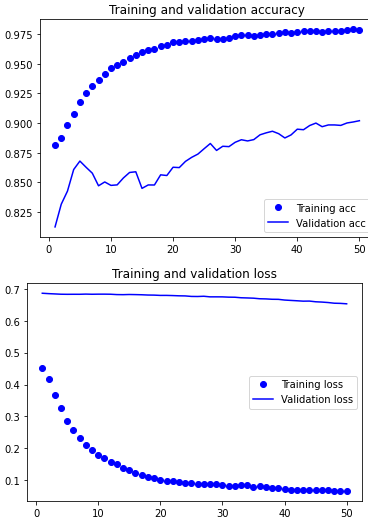

In [ ]:
basic_aug_history = basic_aug_model.fit_generator(train_aug_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=test_aug_generator,
                              validation_steps=16)

In [ ]:
basic_aug_model = load_model('/content/gdrive/MyDrive/savemodel/basic_aug_model.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = basic_aug_history.history['acc']
val_acc = basic_aug_history.history['val_acc']
loss = basic_aug_history.history['loss']
val_loss = basic_aug_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
basic_aug_results = basic_aug_model.evaluate(test_aug_generator, steps=len(test_aug_generator))

63/63 [==============================] - 5s 73ms/step - loss: 0.6492 - acc: 0.9025



*   No_aug=>  loss: 0.2635 - acc: 0.8824  aug => loss: 0.6466 - acc: 0.9025
*   증식generator를 사용했을 때 모델의 학습 결과가 더 좋았음




## ***VGG16 - Pretrained***




*   13개의 convolution layer 와 3개의 fully connected layer로 구성
*   weights = 'imagenet'으로하여 VGG16 모델 사용
*   VGG16모델에 완전 연결 분류기 추가


 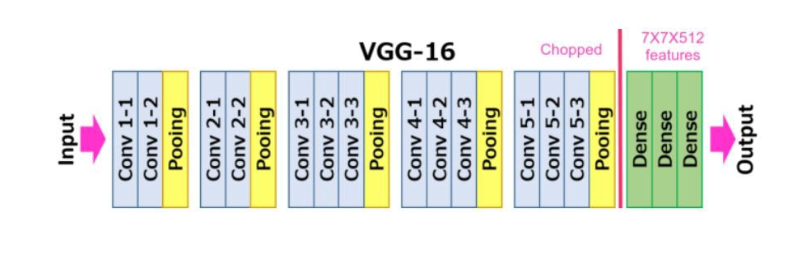





In [ ]:
from tensorflow.keras.applications import VGG16


### conv_base를 VGG16으로
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.trainable = False

conv_base.summary()

from tensorflow.keras import models
from tensorflow.keras import layers


## VGG16 Base 모델에 Dense layer추가
VGG16_model = models.Sequential()
VGG16_model.add(conv_base)

VGG16_model.add(layers.Flatten())
VGG16_model.add(layers.Dense(512, activation='relu'))
VGG16_model.add(layers.Dense(1, activation='sigmoid'))

VGG16_model.summary()

from tensorflow.keras import optimizers

VGG16_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=2e-5),
              metrics=['acc'])

In [ ]:

VGG16_history = VGG16_model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=test_generator,
                              validation_steps=16)

In [ ]:
import matplotlib.pyplot as plt

acc = VGG16_history.history['acc']
val_acc = VGG16_history.history['val_acc']
loss = VGG16_history.history['loss']
val_loss = VGG16_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

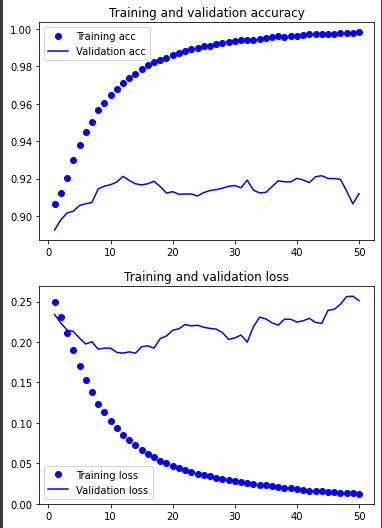



*   overfitting 된 것으로 보임
*   96.95% 정확도의 성능을 보임



In [ ]:
VGG_model = load_model('/content/gdrive/MyDrive/savemodel/VGG16_model.h5')

In [ ]:
VGG_results = VGG_model.evaluate(test_generator, steps=len(test_generator))

63/63 [==============================] - 345s 6s/step - loss: 0.0931 - acc: 0.9695


### VGG16-Finetuning


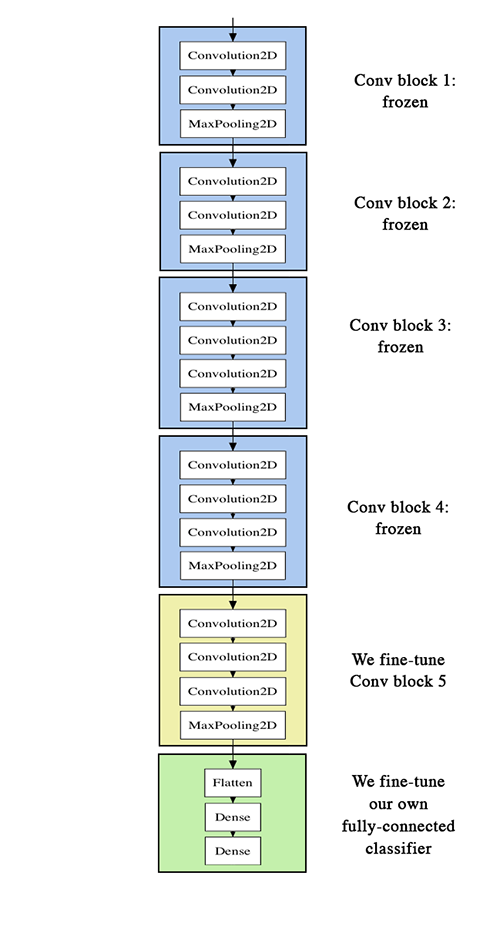



*   conv_base 는 weights = 'imagenet'으로 한 VGG16 모델 사용
*   VGG16모델에서 block4_pool까지는 동결하고 block5_conv1, block5_conv2,block5_conv3는 학습대상이 되도록 조정
*   VGG16모델과 같은 완전연결 분류기 추가






모델 학습

In [ ]:
from tensorflow.keras.applications import VGG16


### conv_base를 VGG16으로
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

from tensorflow.keras import models
from tensorflow.keras import layers


## VGG16 Base 모델에 Dense layer추가
VGG16_model = models.Sequential()
VGG16_model.add(conv_base)
VGG16_model.add(layers.Flatten())
VGG16_model.add(layers.Dense(512, activation='relu'))
VGG16_model.add(layers.Dense(1, activation='sigmoid'))

VGG16_model.summary()



conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable=False


In [ ]:
VGG16_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=2e-5),
              metrics=['acc'])

VGG16_block_history = VGG16_model.fit_generator(train_generator,
                              steps_per_epoch=25,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=10)

VGG16_model.save('/content/gdrive/MyDrive/Project/deeplearning/savemodel/VGG16_model_finetuning.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = VGG16_block_history.history['acc']
val_acc = VGG16_block_history.history['val_acc']
loss = VGG16_block_history.history['loss']
val_loss = VGG16_block_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

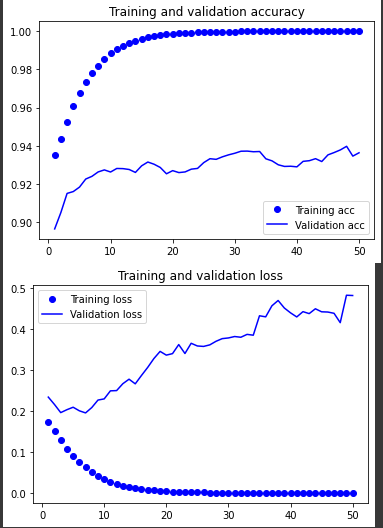

In [ ]:
modify_VGG16_model = load_model('/content/gdrive/MyDrive/savemodel/modify_VGG_model.h5')

In [ ]:
results_modify_VGG = modify_VGG16_model.evaluate(test_generator, steps=len(test_generator))

63/63 [==============================] - 5s 77ms/step - loss: 0.1642 - acc: 0.9750


*   Test Acc => VGG16 : 97%  VGG16-Finetunning : 97.5%
*   검증곡선은 Finetunning을 하기전보다 향상 되었으나 손실곡선은  Finetunning을 하기전보다 악화됨 그러나 정확도는 향상


## ***ResNet50***

*   층이 깊어짐에 따라 back propagtion시 vanishing gradient problem 발생
*    ResNet은 skip connection을 이용한 residual learning을 통해
layer가 깊어짐에 따른 gradient vanishing 문제를 해결하였다.
*   Input X를 그대로 전달받기 때문에 더 작은 변동이 있다.
*   검출을 더 깊은 레이어에서도 가능하게 한다.






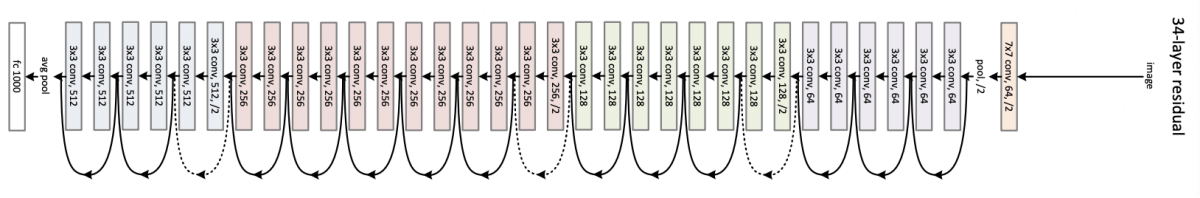

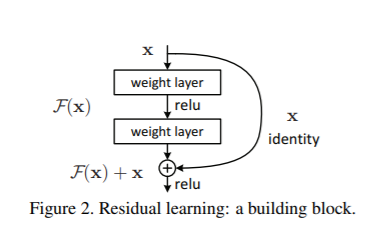







In [ ]:
from keras.layers.pooling import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Flatten

Res_model = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3), pooling=max, classes=2)

Res_model.trainable = False

## ResNet50 모델에 Dense layer추가
Res_new_model = models.Sequential()
Res_new_model.add(Res_model)
Res_new_model.add(layers.Flatten())
Res_new_model.add(layers.Dense(512, activation='relu'))
Res_new_model.add(layers.Dense(1, activation='sigmoid'))

Res_new_model.compile(loss='binary_crossentropy',
                        optimizer=keras.optimizers.Adam(lr=2e-5),
                        metrics=['accuracy'])

Res_new_model.summary()

In [ ]:
# Res_new_model모델 구조 확인
Res_layers = [(layer, layer.name, layer.trainable) for layer in Res_new_model.layers]
pd.DataFrame(Res_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [ ]:
ResNet50_history = Res_new_model.fit_generator(train_generator,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_data=test_generator,
                              validation_steps=16)

In [ ]:
import matplotlib.pyplot as plt

acc = ResNet50_history.history['accuracy']
val_acc = ResNet50_history.history['val_accuracy']
loss = ResNet50_history.history['loss']
val_loss = ResNet50_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

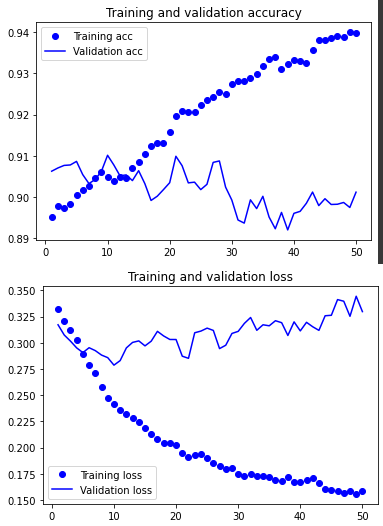

In [ ]:
Res_new_model = load_model('/content/gdrive/MyDrive/savemodel/Resnet50_model.h5')

In [ ]:
res_new_results = Res_new_model.evaluate(test_generator, steps=len(test_generator))

63/63 [==============================] - 6s 81ms/step - loss: 0.1689 - accuracy: 0.9320


### ResNet50 Finetuning



*   Res_new_model을 weight= 'imagenet'으로한 ResNet50으로 설정
*   175개의 layer중 160번째 층까지 동결하고 161번째부터 175번째 layer는 학습이 가능하도록 조정



In [ ]:
from keras.layers.pooling import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Flatten

Res_new_model = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3), pooling=max, classes=2)

# ResNet Freeze => 160번째 층까지 동결

fine_tune_at = 160

for layer in Res_new_model.layers[:fine_tune_at]:
  layer.trainable = False



## ResNet50 모델에 Dense layer추가
Res_modify_model = models.Sequential()
Res_modify_model.add(Res_new_model)
Res_modify_model.add(layers.Flatten())
Res_modify_model.add(layers.Dense(512, activation='relu'))
Res_modify_model.add(layers.Dense(1, activation='sigmoid'))



Res_modify_model.compile(loss='binary_crossentropy',
                        optimizer=keras.optimizers.Adam(lr=2e-5),
                        metrics=['accuracy'])

Res_modify_model.summary()



In [ ]:
# Resnet50 new 모델 구조 확인

Resnet_layers = [(layer, layer.name, layer.trainable) for layer in Res_new_model.layers]
pd.DataFrame(Resnet_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [ ]:
Res_modify_history = Res_modify_model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=test_generator,
                              validation_steps=16)

In [ ]:
import matplotlib.pyplot as plt

acc = Res_modify_history.history['accuracy']
val_acc = Res_modify_history.history['val_accuracy']
loss = Res_modify_history.history['loss']
val_loss = Res_modify_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

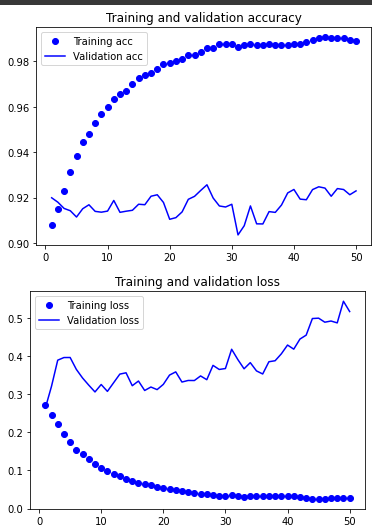

In [ ]:
Res_modify_model = load_model('/content/gdrive/MyDrive/savemodel/Res_modify_model.h5')

In [ ]:
Res_new_model.save('/content/gdrive/MyDrive/Project/deeplearning/savemodel/Resnet50_model.h5')

In [ ]:
res_modify_results = Res_modify_model.evaluate(test_generator, steps=len(test_generator))

63/63 [==============================] - 6s 76ms/step - loss: 0.2054 - accuracy: 0.9605




*   ResNet50  loss: 0.1689 - accuracy: 0.9320  / ResNet-Finetunning loss: 0.1982 - accuracy: 0.9595
*   Tunning 을 통해 accuracy 향상



## ***MobileNet***



*   단순히 채널 수를 증가시키는 VGG16과 같은 파라미터량이 많다
*   MobileNet은  기존의 convolution 연산을 depthwise separable convolution으로 변경
*   계산량을 획기적으로 줄여줌


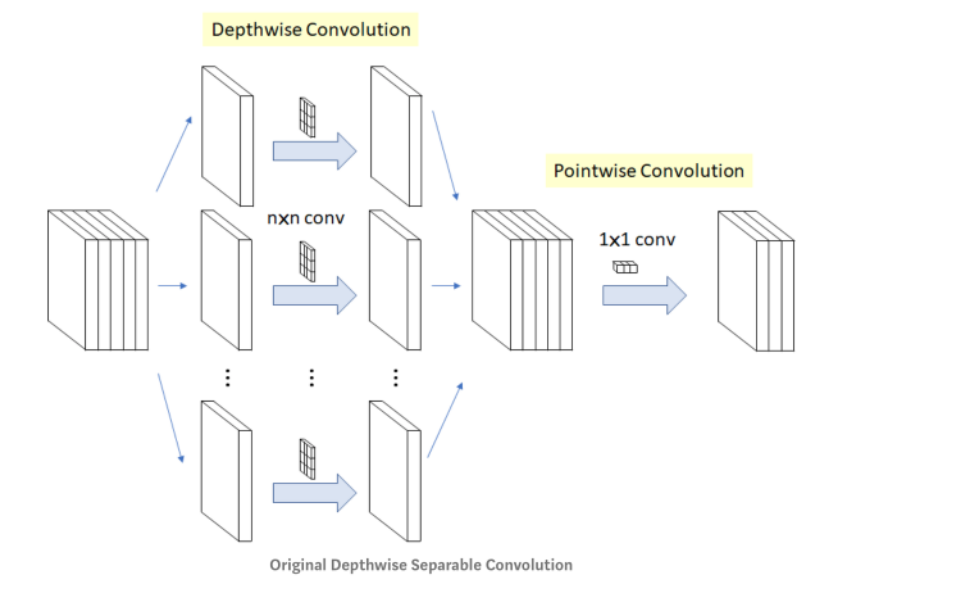


In [ ]:
from tensorflow.keras.applications import MobileNet
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Flatten

Mobile_base_model = MobileNet(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(150,150,3),
    pooling=None,
    classes=2,
    classifier_activation="sigmoid",
)

Mobile_base_model.trainable = False

Mobile_model = models.Sequential()
Mobile_model.add(Mobile_base_model)

Mobile_model.add(layers.Flatten())
Mobile_model.add(layers.Dense(512, activation='relu'))
Mobile_model.add(layers.Dense(1, activation='sigmoid'))


Mobile_model.compile(loss='binary_crossentropy',
                        optimizer=keras.optimizers.Adam(lr=2e-5),
                        metrics=['accuracy'])
Mobile_model.summary()

In [ ]:
xception_layers = [(layer, layer.name, layer.trainable) for layer in xception_model.layers]
pd.DataFrame(xception_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [ ]:
Mobile_history = Mobile_model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=test_generator,
                              validation_steps=16)

In [ ]:
import matplotlib.pyplot as plt

acc = Mobile_history.history['accuracy']
val_acc = Mobile_history.history['val_accuracy']
loss = Mobile_history.history['loss']
val_loss = Mobile_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

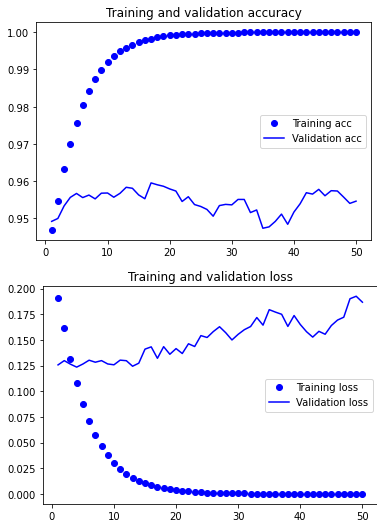

In [ ]:
Mobile_model = load_model('/content/gdrive/MyDrive/savemodel/Mobile_model.h5')

In [ ]:
Mobile_results = Mobile_model.evaluate(test_generator, steps=len(test_generator))

63/63 [==============================] - 6s 78ms/step - loss: 0.0659 - accuracy: 0.9825


In [ ]:
Mobile_model.save('/content/gdrive/MyDrive/savemodel/Mobile_model.h5')

### ***MobileNetV3***

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Flatten

MobileV3_base_model = MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(150,150,3),
    pooling=None,
    classes=2,
    classifier_activation="sigmoid",
)

MobileV3_base_model.trainable = False

MobileV3_model = models.Sequential()
MobileV3_model.add(MobileV3_base_model)

MobileV3_model.add(layers.Flatten())
MobileV3_model.add(layers.Dense(512, activation='relu'))
MobileV3_model.add(layers.Dense(1, activation='sigmoid'))


MobileV3_model.compile(loss='binary_crossentropy',
                        optimizer=keras.optimizers.Adam(lr=2e-5),
                        metrics=['accuracy'])
MobileV3_model.summary()

In [ ]:
MobileV3_history = MobileV3_model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=test_generator,
                              validation_steps=16)

In [ ]:
import matplotlib.pyplot as plt

acc = MobileV3_history.history['accuracy']
val_acc = MobileV3_history.history['val_accuracy']
loss = MobileV3_history.history['loss']
val_loss = MobileV3_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

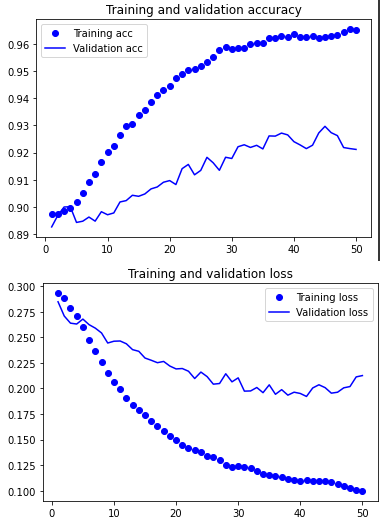

In [ ]:
MobileV3_model = load_model('/content/gdrive/MyDrive/savemodel/MobileV3_model.h5')

In [ ]:
MobileV3_results = MobileV3_model.evaluate(test_generator, steps=len(test_generator))

63/63 [==============================] - 6s 78ms/step - loss: 0.1235 - accuracy: 0.9430


In [ ]:
MobileV3_model.save('/content/gdrive/MyDrive/savemodel/MobileV3_model.h5')

# ***CNN모델 성능비교***

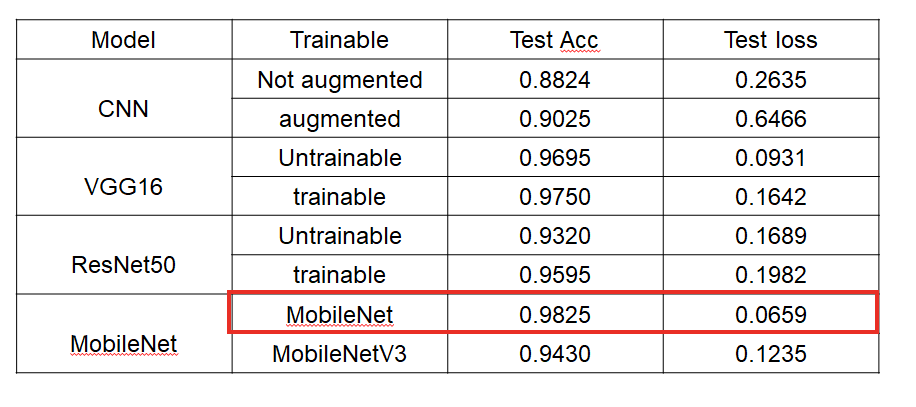



*   MobileNet의 정확도가 98.25%로 가장 좋은 성능을 보였음



# YOLOv5를 통한 사람의 머리 인식 모델 학습

## 데이터 전처리

In [ ]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

YOLO 좌표 및 label 정보 저장하는 txt파일 생성

In [ ]:
createFolder('/content/gdrive/MyDrive/Project/deeplearning/RawData/txt_data2')

In [ ]:
def to_yolo_transform(x1, y1, x2, y2, width, height):

  X = ((x1+x2)/2)/width
  Y = ((y1+y2)/2)/height
  W = (x2-x1)/width
  H = (y2-y1)/height

  if X>=1 : X = 1
  if Y>=1 : Y = 1
  if W>=1 : W = 1
  if H>=1 : H = 1


  return X,Y,W,H

In [ ]:
json_lists = os.listdir('/content/gdrive/MyDrive/Project/deeplearning/RawData/json_data')

for k in tqdm(range(len(json_lists))) :
    with open('/content/gdrive/MyDrive/Project/deeplearning/RawData/json_data/{}'.format(json_lists[k]), 'r', encoding = "utf-8-sig") as f:

        json_data = json.load(f)

    f = open("/content/gdrive/MyDrive/Project/deeplearning/RawData/txt_data2/{}.txt".format(json_data['image']['filename'].split('.')[0]), 'w')

    for i in range(len(json_data['annotations'])) :
        if (int(json_data['annotations'][i]['class'])==7) or (int(json_data['annotations'][i]['class'])==8) :
            box = json_data['annotations'][i]['box']
            width = json_data['image']['resolution'][0]
            height = json_data['image']['resolution'][1]
            x, y, w, h = to_yolo_transform(box[0], box[1], box[2], box[3], width, height)
            data = '0 ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + '\n'
            f.write(data)
        else :
            pass


    f.close()

Train, Validation, Test 파일 생성

In [ ]:
for i in ['train', 'valid', 'test'] :
  createFolder('/content/drive/MyDrive/Project/deeplearning/dataset2/{}'.format(i))
  createFolder('/content/drive/MyDrive/Project/deeplearning/dataset2/{}/images'.format(i))
  createFolder('/content/drive/MyDrive/Project/deeplearning/dataset2/{}/labels'.format(i))

In [ ]:
img_src = '/content/gdrive/MyDrive/Project/deeplearning/RawData/img_data/'
txt_src = '/content/gdrive/MyDrive/Project/deeplearning/RawData/txt_data2/'
img_lists = sorted(os.listdir(img_src))

size = len(img_lists)
train_len = int(size * 0.8)
valid_len = int((size - train_len)/2)
test_len = size - train_len - valid_len

for i in tqdm(range(train_len)) :
  filename = img_lists[i].split('.')[0]
  src = img_src
  dir = '/content/drive/MyDrive/Project/deeplearning/dataset2/train/'
  shutil.copy(img_src + filename + '.jpg', dir + 'images/' + filename + '.jpg')
  shutil.copy(txt_src + filename + '.txt', dir + 'labels/' + filename + '.txt')

img_lists = sorted(os.listdir(img_src))
for i in tqdm(range(valid_len)) :
  filename = img_lists[i].split('.')[0]
  src = img_src
  dir = '/content/drive/MyDrive/Project/deeplearning/dataset2/valid/'
  shutil.copy(img_src + filename + '.jpg', dir + 'images/' + filename + '.jpg')
  shutil.copy(txt_src + filename + '.txt', dir + 'labels/' + filename + '.txt')

img_lists = sorted(os.listdir(img_src))
for i in tqdm(range(test_len)) :
  filename = img_lists[i].split('.')[0]
  src = img_src
  dir = '/content/drive/MyDrive/Project/deeplearning/dataset2/test/'
  shutil.copy(img_src + filename + '.jpg', dir + 'images/' + filename + '.jpg')
  shutil.copy(txt_src + filename + '.txt', dir + 'labels/' + filename + '.txt')

## YOLOv5 학습하기

In [ ]:
%cd /content/gdrive/MyDrive/Project/deeplearning/detection
!git clone https://github.com/ultralytics/yolov5

In [ ]:
%cd /content/gdrive/MyDrive/Project/deeplearning/detection/yolov5
!pip install -r requirements.txt

In [ ]:
%cat /content/gdrive/MyDrive/Project/deeplearning/dataset2/data.yaml

names: [person]
nc: 1
train: /content/drive/MyDrive/ColabNotebooks/deeplearning/project/dataset/train.txt
val: /content/drive/MyDrive/ColabNotebooks/deeplearning/project/dataset/valid.txt


In [ ]:
train_img_list = glob('/content/drive/MyDrive/Project/deeplearning/dataset2/train/images/*.jpg')
val_img_list = glob('/content/drive/MyDrive/Project/deeplearning/dataset2/valid/images/*.jpg')

In [ ]:
with open('/content/drive/MyDrive/Project/deeplearning/dataset2/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list) + '\n')

with open('/content/drive/MyDrive/Project/deeplearning/dataset2/val.txt', 'w') as f:
  f.write('\n'.join(val_img_list) + '\n')

In [ ]:
import yaml

with open('/content/drive/MyDrive/Project/deeplearning/dataset2/data.yaml', 'r') as f:
  data = yaml.safe_load(f)

print(data)

data['train'] = '/content/drive/MyDrive/Project/deeplearning/dataset2/train.txt'
data['val'] = '/content/drive/MyDrive/Project/deeplearning/dataset2/val.txt'

with open('/content/drive/MyDrive/Project/deeplearning/dataset2/data.yaml', 'w') as f:
  yaml.dump(data, f)

print(data)

In [ ]:
%cd /content/drive/MyDrive/Project/deeplearning/detection/yolov5

# 이미지 크기 416 / 배치 사이즈 100 / 에포크 40 으로 학습
!python train.py --img 416 --batch 100 --epochs 40 --data /content/drive/MyDrive/Project/deeplearning/dataset2/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name img416_batch100_epoch40_yolov5s_results

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Project/deeplearning/detection/yolov5/runs/train

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/content/drive/MyDrive/Project/deeplearning/FINAL/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

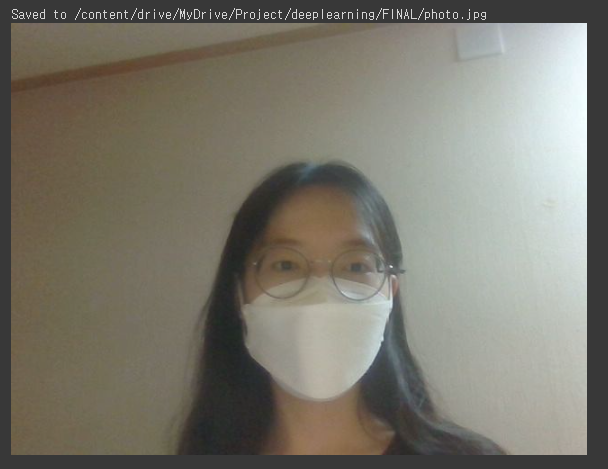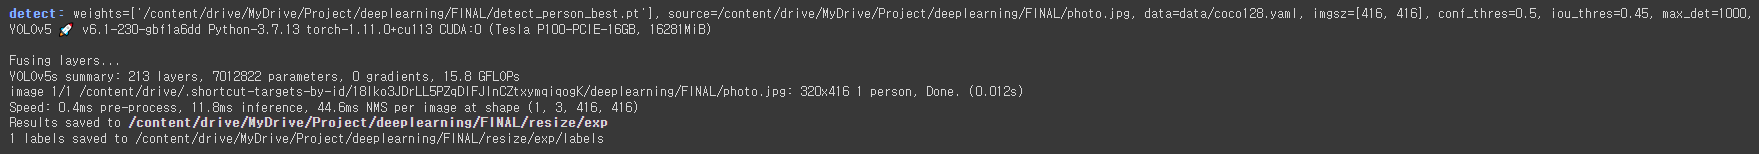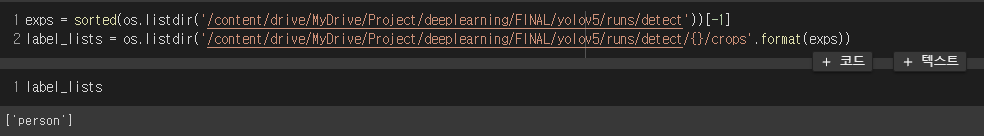

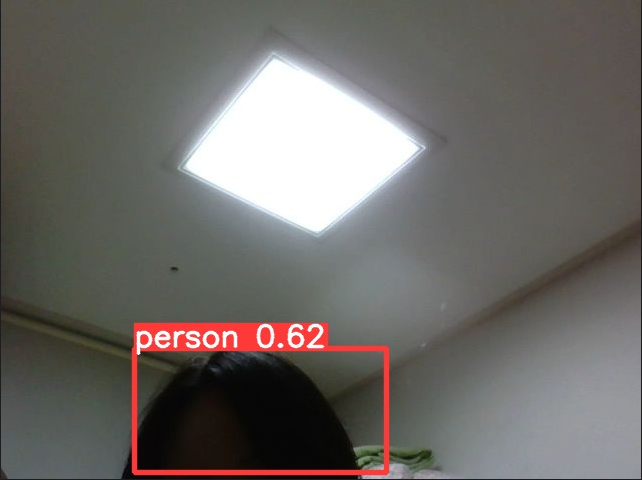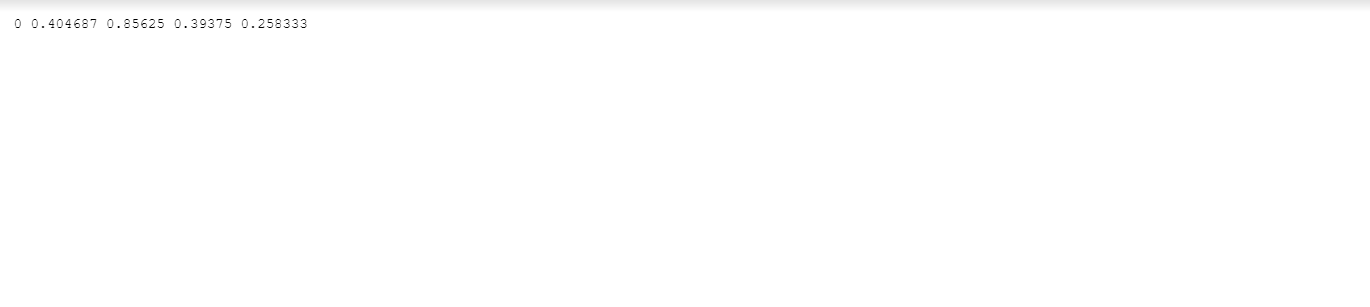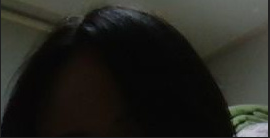

# YOLOv5를 통한 안전모 착용여부 인식 모델 학습

## 데이터 전처리

In [ ]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

YOLO 좌표 및 label 정보 저장하는 txt파일 생성

In [ ]:
createFolder('/content/gdrive/MyDrive/Project/deeplearning/RawData/txt_data')

In [ ]:
def to_yolo_transform(x1, y1, x2, y2, width, height):

  X = ((x1+x2)/2)/width
  Y = ((y1+y2)/2)/height
  W = (x2-x1)/width
  H = (y2-y1)/height

  if X>=1 : X = 1
  if Y>=1 : Y = 1
  if W>=1 : W = 1
  if H>=1 : H = 1


  return X,Y,W,H

In [ ]:
json_lists = os.listdir('/content/gdrive/MyDrive/Project/deeplearning/RawData/json_data')

for k in tqdm(range(len(json_lists))) :
    with open('/content/gdrive/MyDrive/Project/deeplearning/RawData/json_data/{}'.format(json_lists[k]), 'r', encoding = "utf-8-sig") as f:

        json_data = json.load(f)

    f = open("/content/gdrive/MyDrive/Project/deeplearning/RawData/txt_data/{}.txt".format(json_data['image']['filename'].split('.')[0]), 'w')

    for i in range(len(json_data['annotations'])) :
        if (int(json_data['annotations'][i]['class'])==7) or (int(json_data['annotations'][i]['class'])==8) :
            box = json_data['annotations'][i]['box']
            width = json_data['image']['resolution'][0]
            height = json_data['image']['resolution'][1]
            x, y, w, h = to_yolo_transform(box[0], box[1], box[2], box[3], width, height)
            if json_data['annotations'][i]['class'] =='07' :
                label = '1'
            else :
                label = '0'
            data = label + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + '\n'
            f.write(data)
        else :
            pass


    f.close()

Train, Validation, Test 파일 생성


In [ ]:
for i in ['train', 'valid', 'test'] :
  createFolder('/content/drive/MyDrive/Project/deeplearning/dataset/{}'.format(i))
  createFolder('/content/drive/MyDrive/Project/deeplearning/dataset/{}/images'.format(i))
  createFolder('/content/drive/MyDrive/Project/deeplearning/dataset/{}/labels'.format(i))

In [ ]:
img_src = '/content/gdrive/MyDrive/Project/deeplearning/RawData/img_data/'
txt_src = '/content/gdrive/MyDrive/Project/deeplearning/RawData/txt_data/'
img_lists = sorted(os.listdir(img_src))

size = len(img_lists)
train_len = int(size * 0.8)
valid_len = int((size - train_len)/2)
test_len = size - train_len - valid_len

for i in tqdm(range(train_len)) :
  filename = img_lists[i].split('.')[0]
  src = img_src
  dir = '/content/drive/MyDrive/Project/deeplearning/dataset/train/'
  shutil.copy(img_src + filename + '.jpg', dir + 'images/' + filename + '.jpg')
  shutil.copy(txt_src + filename + '.txt', dir + 'labels/' + filename + '.txt')

img_lists = sorted(os.listdir(img_src))
for i in tqdm(range(valid_len)) :
  filename = img_lists[i].split('.')[0]
  src = img_src
  dir = '/content/drive/MyDrive/Project/deeplearning/dataset/valid/'
  shutil.copy(img_src + filename + '.jpg', dir + 'images/' + filename + '.jpg')
  shutil.copy(txt_src + filename + '.txt', dir + 'labels/' + filename + '.txt')

img_lists = sorted(os.listdir(img_src))
for i in tqdm(range(test_len)) :
  filename = img_lists[i].split('.')[0]
  src = img_src
  dir = '/content/drive/MyDrive/Project/deeplearning/dataset/test/'
  shutil.copy(img_src + filename + '.jpg', dir + 'images/' + filename + '.jpg')
  shutil.copy(txt_src + filename + '.txt', dir + 'labels/' + filename + '.txt')

In [ ]:
print(len(glob('/content/drive/MyDrive/Project/deeplearning/dataset/train/images/*.jpg')))
print(len(glob('/content/drive/MyDrive/Project/deeplearning/dataset/train/labels/*.txt')))
print(len(glob('/content/drive/MyDrive/Project/deeplearning/dataset/valid/images/*.jpg')))
print(len(glob('/content/drive/MyDrive/Project/deeplearning/dataset/valid/labels/*.txt')))
print(len(glob('/content/drive/MyDrive/Project/deeplearning/dataset/test/images/*.jpg')))
print(len(glob('/content/drive/MyDrive/Project/deeplearning/dataset/test/labels/*.txt')))

## YOLOv5 학습하기

In [ ]:
%cd /content/gdrive/MyDrive/Project/deeplearning
!git clone https://github.com/ultralytics/yolov5

In [ ]:
%cd /content/gdrive/MyDrive/Project/deeplearning/yolov5
!pip install -r requirements.txt

In [ ]:
%cat /content/gdrive/MyDrive/Project/deeplearning/dataset/data.yaml

In [ ]:
train_img_list = glob('/content/drive/MyDrive/Project/deeplearning/dataset/train/images/*.jpg')
val_img_list = glob('/content/drive/MyDrive/Project/deeplearning/dataset/valid/images/*.jpg')

In [ ]:
with open('/content/drive/MyDrive/Project/deeplearning/dataset/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list) + '\n')

with open('/content/drive/MyDrive/Project/deeplearning/dataset/val.txt', 'w') as f:
  f.write('\n'.join(val_img_list) + '\n')

In [ ]:
import yaml

with open('/content/drive/MyDrive/Project/deeplearning/dataset/data.yaml', 'r') as f:
  data = yaml.safe_load(f)

print(data)

data['train'] = '/content/drive/MyDrive/Project/deeplearning/dataset/train.txt'
data['val'] = '/content/drive/MyDrive/Project/deeplearning/dataset/val.txt'

with open('/content/drive/MyDrive/Project/deeplearning/dataset/data.yaml', 'w') as f:
  yaml.dump(data, f)

print(data)

In [ ]:
%cd /content/drive/MyDrive/Project/deeplearning/yolov5

!python train.py --img 416 --batch 64 --epochs 50 --data /content/drive/MyDrive/Project/deeplearning/dataset/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name img416_batch100_epoch50_yolov5s_results

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Project/deeplearning/yolov5/runs/train

### 학습한 결과

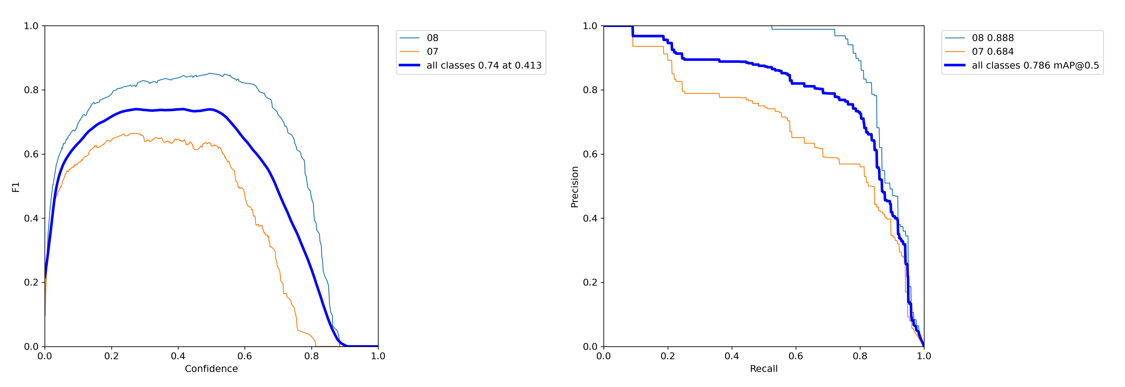

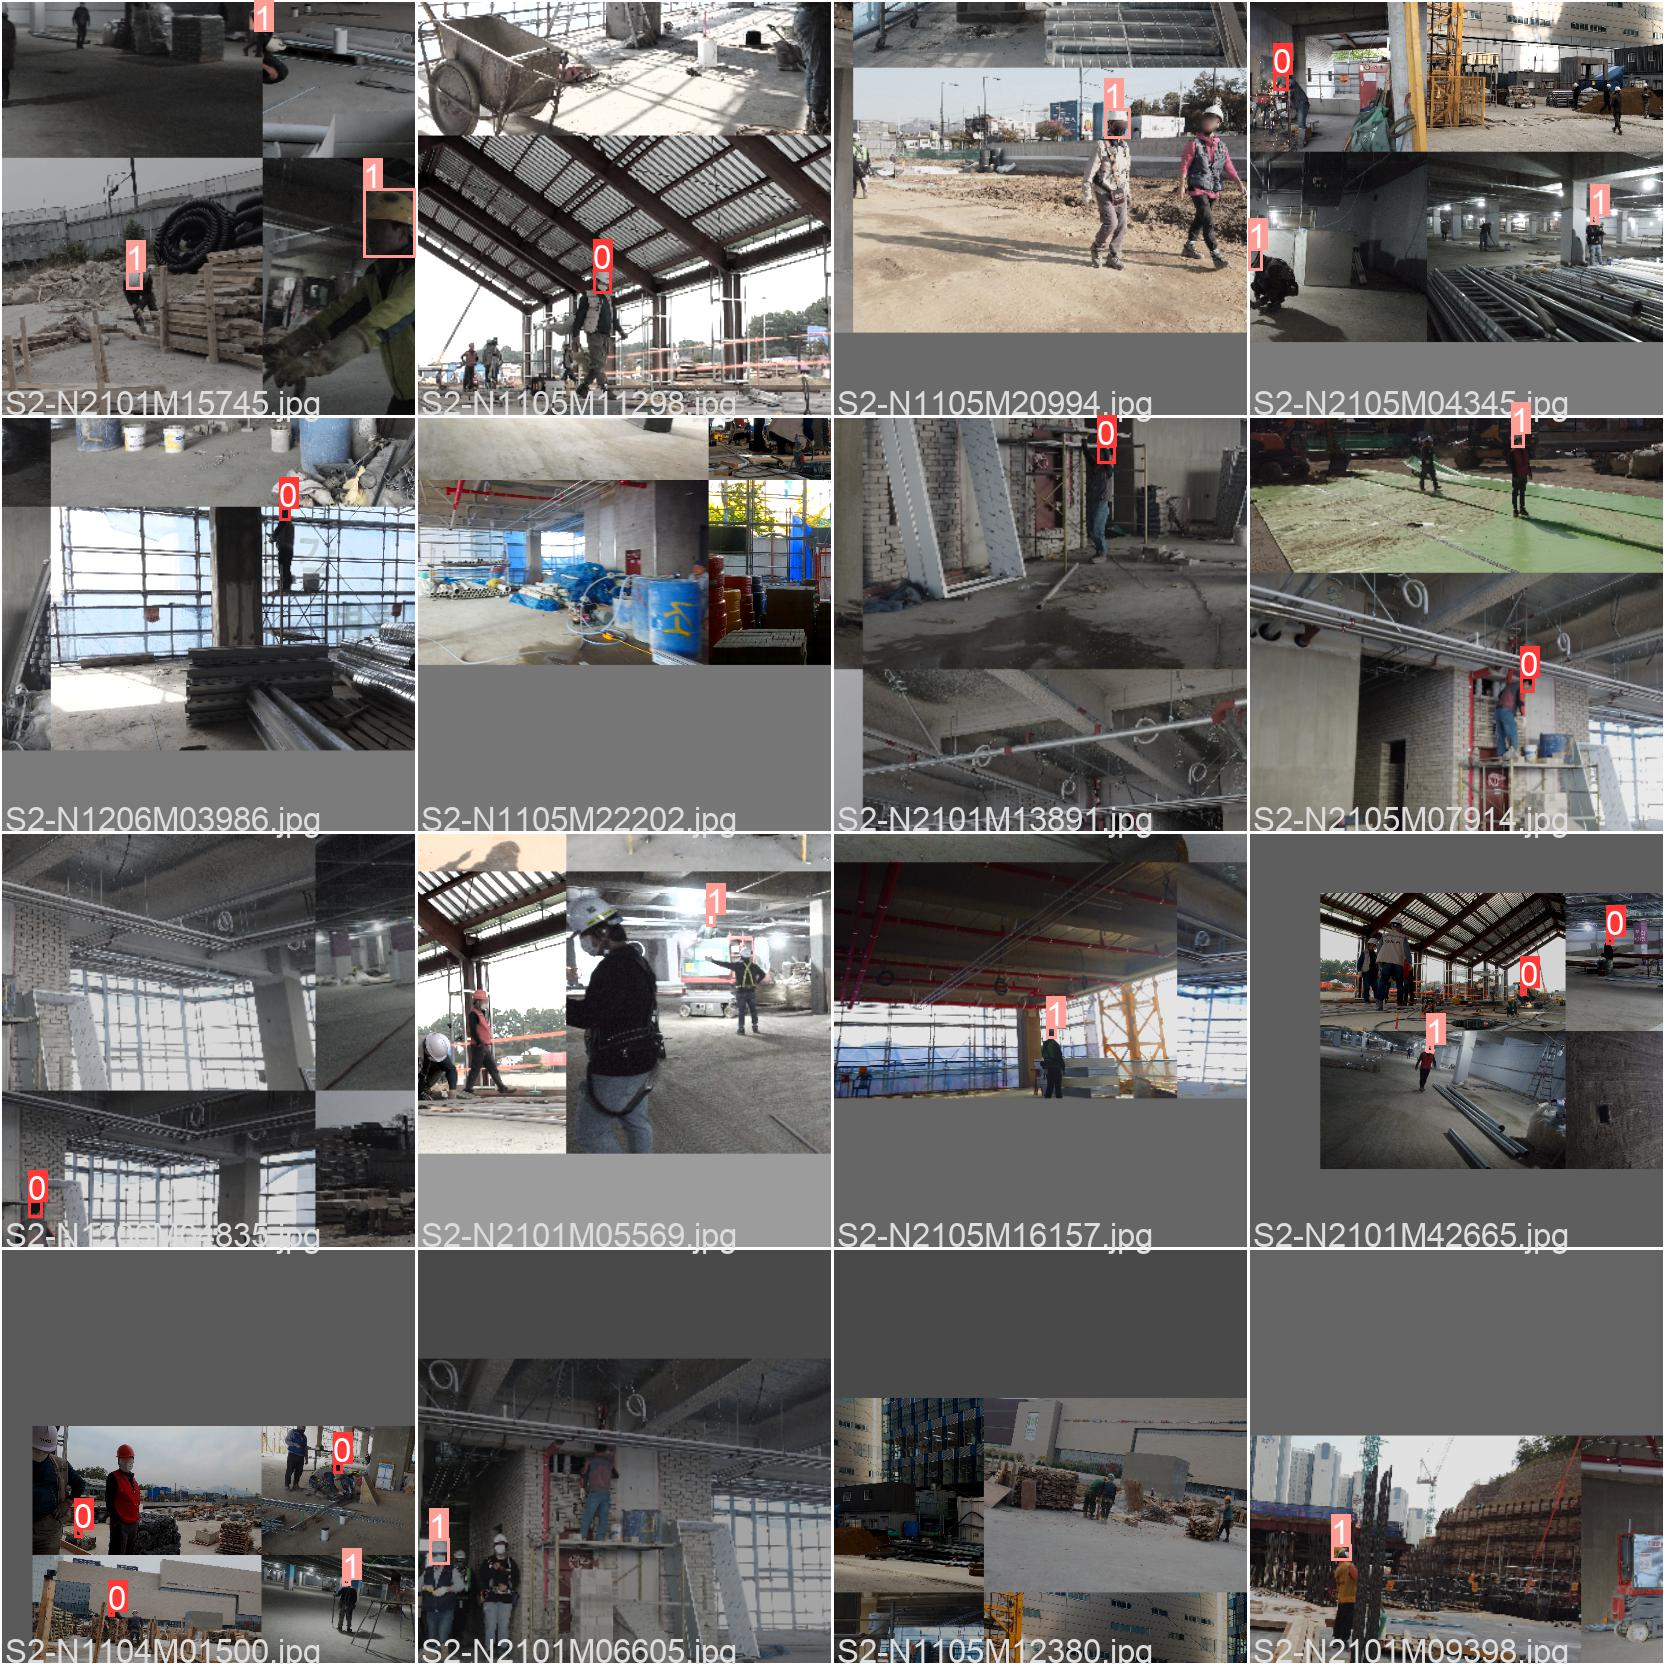

# ***Conclusion***



*   데이터의 불균형이나 데이터의 잘못된 라벨링 등이 문제점이라 생각
*  이미지 크기에 비해 현저히 작은 인식 크기
*   Detection을 보완하여 건설현장에 적용한다면 유의미한 성과가 있을 것



# ***Reference***



*   Identity Mappings in Deep Residual Networks (Kaiming He 외 3명 , 2016)
*   MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications (Andrew G. Howard, 외 7명 , 2017)
*   VERY DEEP CONVOLUTIONAL
NETWORKS
FOR
LARGE-SCALE
IMAGE
RECOGNITION (Karen Simonyan
∗ & Andrew Zisserman , 2015)



